<a href="https://colab.research.google.com/github/singhvertika119/Learning-DL-Pytorch/blob/main/digitClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from google.colab import files
from PIL import Image


In [2]:
# check availability of GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cpu


In [3]:
# transform image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# download dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.96MB/s]


In [5]:
# create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Define neural network
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
    x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
    x = x.view(-1, 64 * 7 * 7)            # Flatten
    x = F.relu(self.fc1(x))               # Fully connected
    x = self.fc2(x)                       # Output layer
    return x

In [7]:
# initialize model, loss function, optimizer
model = CNN().to(device)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cpu


In [9]:
# save model
torch.save(model.state_dict(), "mnist_model.pth")
print("Model saved successfully!")
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("mnist_model.pth"))
loaded_model.to(device)  # Move the loaded model to the same device as the original model
loaded_model.eval()
print("model loaded successfully")

Model saved successfully!
model loaded successfully


In [10]:
# training loop
epochs = 10
for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10, Loss: 0.1512
Epoch 2/10, Loss: 0.0467
Epoch 3/10, Loss: 0.0307
Epoch 4/10, Loss: 0.0230
Epoch 5/10, Loss: 0.0183
Epoch 6/10, Loss: 0.0141
Epoch 7/10, Loss: 0.0125
Epoch 8/10, Loss: 0.0089
Epoch 9/10, Loss: 0.0073
Epoch 10/10, Loss: 0.0071


Accuracy on test set: 99.09%


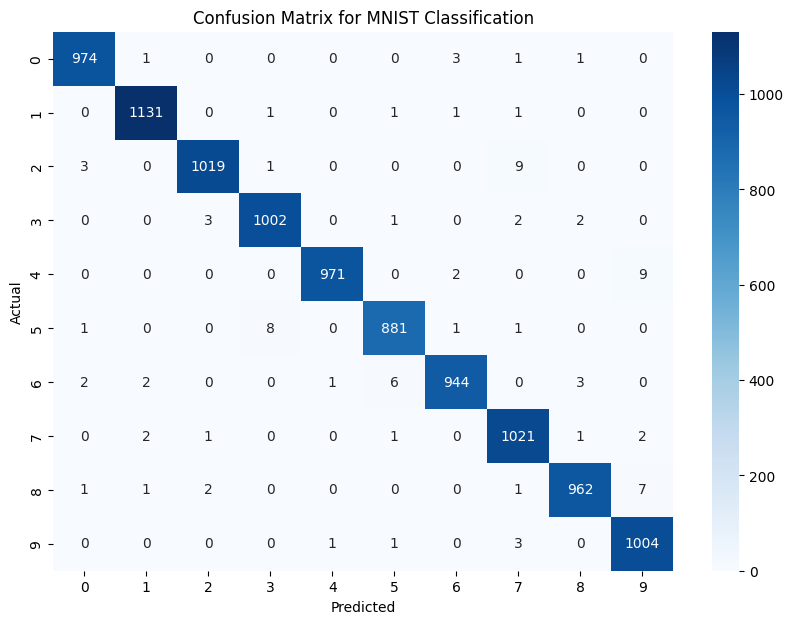

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      1.00      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [11]:
# testing the model
model.eval()
correct, total = 0, 0
all_labels = []
all_preds = []
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MNIST Classification")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds))

In [12]:
# test on a random sample
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# dummy tensor for testing
dummy_input = torch.rand(1, 1, 28, 28)
dummy_input = dummy_input.to(device) # Move dummy input to the same device as the model
output = loaded_model(dummy_input)
print("Model ouput:", output)
predicted_digit = torch.argmax(output, dim=1).item()
print(f"Predicted digit: {predicted_digit}")

Model ouput: tensor([[-0.0103,  0.0098, -0.0458,  0.0170, -0.0341,  0.0064, -0.0250,  0.0356,
         -0.0304,  0.1274]], grad_fn=<AddmmBackward0>)
Predicted digit: 9


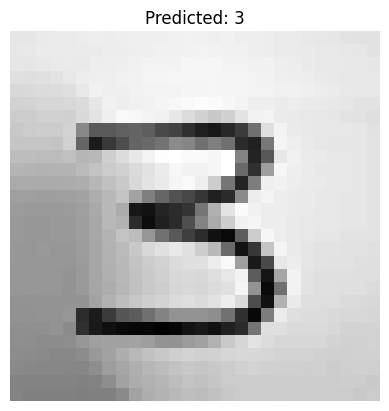

In [68]:
# Show the image
plt.imshow(img_tensor.cpu().squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted.item()}")
plt.axis('off')
plt.show()

In [57]:
uploaded = files.upload()
# load the uploaded image
for fn in uploaded.keys():
  img_path = fn

# preprocess the image
img = Image.open(img_path).convert('L')
img = img.resize((28, 28))
# Convert to tensor
img_array = np.array(img)
img_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
# move to gpu
img_tensor = img_tensor.to(device)
print(device)

Saving WhatsApp Image 2025-08-17 at 15.41.24_07c8c1a5.jpg to WhatsApp Image 2025-08-17 at 15.41.24_07c8c1a5 (1).jpg
cpu


Step 1: Original Uploaded Image


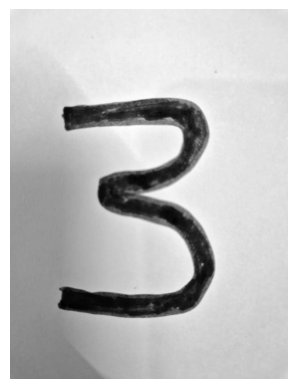

In [58]:
print("Step 1: Original Uploaded Image")
img = Image.open(img_path).convert('L')   # grayscale
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

In [59]:
img = img.resize((28, 28))
img_array = np.array(img)
print("Step 2: Image shape after resize:", img_array.shape)

Step 2: Image shape after resize: (28, 28)


In [60]:
img_array = np.array(img)
img_array = 255 - img_array

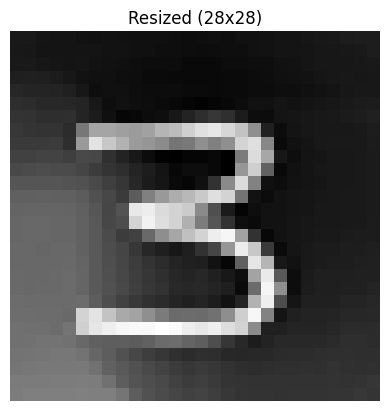

In [61]:
plt.imshow(img_array, cmap="gray")
plt.title("Resized (28x28)")
plt.axis("off")
plt.show()

In [62]:
if img_array.mean() < 128:
    print("Inverting image (black background detected)")
    img_array = 255 - img_array

Inverting image (black background detected)


In [63]:
img_tensor = torch.tensor(img_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
print("Step 4: Tensor shape:", img_tensor.shape)  # (1,1,28,28)
print("Min-Max pixel values:", img_tensor.min().item(), img_tensor.max().item())

Step 4: Tensor shape: torch.Size([1, 1, 28, 28])
Min-Max pixel values: 0.0470588244497776 0.7882353067398071


In [64]:
img_flat = img_tensor.view(img_tensor.size(0), -1)
print("Step 5: Flattened shape:", img_flat.shape)  # (1,784)

Step 5: Flattened shape: torch.Size([1, 784])


In [65]:
img_flat = img_flat.to(device)

In [66]:
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)

print("Step 7: Raw logits:", outputs)

Step 7: Raw logits: tensor([[-0.2843, -5.4877,  0.6695,  3.1167, -7.0705, -0.0651, -2.1934, -3.4554,
          0.2728,  0.7751]])


In [67]:
_, predicted = torch.max(outputs, 1)
print("Step 8: Predicted Digit =", predicted.item())

Step 8: Predicted Digit = 3
